In [1]:
import matplotlib.pyplot as plt
import numpy as np
import ot as pot
import torch
from torchdyn.datasets import *
from numpy.linalg import norm 

2023-09-26 08:36:15.039373: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-26 08:36:16.622853: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-26 08:36:19.126542: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-09-26 08:36:19.127451: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

In [2]:
def generate_sphere_point_cloud(num_points, radius=1):
    phi = torch.rand(num_points) * 2 * math.pi
    theta = torch.acos(2 * torch.rand(num_points) - 1)

    x = radius * torch.sin(theta) * torch.cos(phi)
    y = radius * torch.sin(theta) * torch.sin(phi)
    z = radius * torch.cos(theta)

    return torch.stack((x, y, z), dim=1)

# Parameters
n_samples = 5000

# Generate a sphere point cloud with 5000 points and radius 1
sphere_cloud = generate_sphere_point_cloud(n_samples, radius=1)

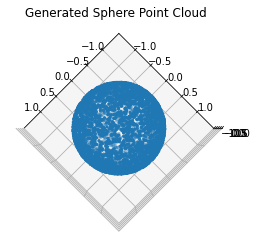

In [3]:
# Visualize the point cloud
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(sphere_cloud[:, 0], sphere_cloud[:, 1], sphere_cloud[:, 2], s=5)
ax.set_aspect('equal')
ax.set_title("Generated Sphere Point Cloud")
ax.view_init(90, 40)
plt.show()

In [4]:
import math

def eight_normal_sample(n, dim, scale=1, var=1):
    m = torch.distributions.multivariate_normal.MultivariateNormal(
        torch.zeros(dim), math.sqrt(var) * torch.eye(dim)
    )
    centers = [
        (1, 0),
        (-1, 0),
        (0, 1),
        (0, -1),
        (1.0 / np.sqrt(2), 1.0 / np.sqrt(2)),
        (1.0 / np.sqrt(2), -1.0 / np.sqrt(2)),
        (-1.0 / np.sqrt(2), 1.0 / np.sqrt(2)),
        (-1.0 / np.sqrt(2), -1.0 / np.sqrt(2)),
    ]
    centers = torch.tensor(centers) * scale
    noise = m.sample((n,))
    multi = torch.multinomial(torch.ones(8), n, replacement=True)
    data = []
    for i in range(n):
        data.append(centers[multi[i]] + noise[i])
    data = torch.stack(data)
    return data

def normal_sample(n, dim):
    m = torch.distributions.multivariate_normal.MultivariateNormal(
        torch.zeros(dim), torch.eye(dim)
    )
    return m.sample_n(n)

class MLP(torch.nn.Module):
    def __init__(self, dim, w=512, time_varying=False):
        super().__init__()
        self.time_varying = time_varying
        self.net = torch.nn.Sequential(
            torch.nn.Linear(dim + (1 if time_varying else 0), w),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(w, w),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(w, w),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(w, w),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(w, dim),
        )

    def forward(self, x):
        return self.net(x)


In [5]:
import torchdyn
from torchdyn.core import NeuralODE

class CNF(torch.nn.Module):
    def __init__(self, net, trace_estimator=None, noise_dist=None):
        super().__init__()
        self.net = net
        self.trace_estimator = trace_estimator if trace_estimator is not None else autograd_trace
        self.noise_dist, self.noise = noise_dist, None

    def forward(self, t, x):
        with torch.set_grad_enabled(True):
            x_in = x[:, 1:].requires_grad_(
                True
            )  # first dimension reserved to divergence propagation
            # the neural network will handle the data-dynamics here
            x_out = self.net(torch.cat([x_in, t * torch.ones(x.shape[0], 1)], dim=-1))
            trJ = self.trace_estimator(x_out, x_in, noise=self.noise)
        return (
            torch.cat([-trJ[:, None], x_out], 1) + 0 * x
        )  # `+ 0*x` has the only purpose of connecting x[:, 0] to autograd graph

    def backward(self, t, x):
        with torch.set_grad_enabled(True):
            x_in = x[:, 1:].requires_grad_(
                True
            )  # first dimension reserved to divergence propagation
            # the neural network will handle the data-dynamics here
            x_out = -self.net(torch.cat([x_in, t * torch.ones(x.shape[0], 1)], dim=-1))
            trJ = self.trace_estimator(x_out, x_in, noise=self.noise)
        return (
            torch.cat([-trJ[:, None], x_out], 1) + 0 * x
        )  # `+ 0*x` has the only purpose of connecting x[:, 0] to autograd graph

In [6]:
x_0 = sphere_cloud[0]
x_1 = sphere_cloud[1]
x_0

tensor([ 0.6536,  0.3836, -0.6525])

In [45]:
import time

# First loss
sigma_min = 0.05
dim = 3
model = MLP(dim=dim, time_varying=True)



batch_size = 256
optimizer = torch.optim.Adam(model.parameters())

start = time.time()
for k in range(1000):
    optimizer.zero_grad()
    #t = torch.linspace(0, 1, steps = batch_size)
    #i = torch.randint(2, batch_size, (1,))
    t = torch.rand(1)
    x0 = x_0.repeat((batch_size, 1)) 
    x1 = x_1.repeat((batch_size, 1)) + normal_sample(batch_size, dim)
    xt = (x1 - x0) * t
    
    #xt = x_init 
    """
    # sample some random times
    a, b = pot.unif(x0.size()[0]), pot.unif(x1.size()[0])
    M = torch.cdist(x0, x1) ** 2
    M = M / M.max()
    # pi = pot.sinkhorn(a, b, M.detach().cpu().numpy(), reg=0.01)
    pi = pot.unbalanced.sinkhorn_knopp_unbalanced(a, b, M.detach().cpu().numpy(), 0.01, reg_m=10)
    # Sample random interpolations on pi
    p = pi.flatten()
    p = p / p.sum()
    choices = np.random.choice(pi.shape[0] * pi.shape[1], p=p, size=batch_size)
    i, j = np.divmod(choices, pi.shape[1])
    """
    
    mu_t = x_0 * (1 - t) + x_1 * t
    sigma_t = sigma_min
    x = mu_t + sigma_t * normal_sample(batch_size, dim).float()
    ut = x_1 - x_0
    vt = model(torch.cat([x, t], dim=-1))
    loss = torch.mean((vt - ut) ** 2)
    loss.backward()
    optimizer.step()
    if k % 100 == 0:
        end = time.time()
        print(f"{k}: loss {loss.item():0.3f} time {(end - start) / 100:0.2f}")
        start = end
        continue

RuntimeError: The size of tensor a (3) must match the size of tensor b (256) at non-singleton dimension 1

In [49]:
torch.rand(10)[torch.randint(3, 5, (1,))]

tensor([0.3263])

In [13]:
torch.save(model, "geo.pt")

In [14]:
model = torch.load("geo.pt")

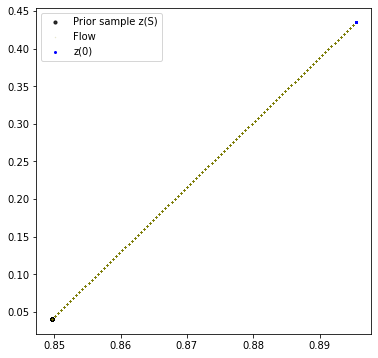

In [30]:
class torch_wrapper(torch.nn.Module):
    """Wraps model to torchdyn compatible format."""

    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, t, x):
        return model(torch.cat([x, t.repeat(x.shape[0])[:, None]], 1))


node = NeuralODE(
    torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-1, rtol=1e-1
)
dim = 3
full_traj = (
    node.trajectory(
        x_1.repeat((64, 1)).float(),
        t_span=torch.linspace(1, 0, 100),
    )
    .detach()
    .cpu()
)
full_traj.shape
traj = full_traj
n = 2000
plt.figure(figsize=(6, 6))
plt.scatter(traj[0, :n, 0], traj[0, :n, 1], s=10, alpha=0.8, c="black")
plt.scatter(traj[:, :n, 0], traj[:, :n, 1], s=0.2, alpha=0.2, c="olive")
plt.scatter(traj[-1, :n, 0], traj[-1, :n, 1], s=4, alpha=1, c="blue")
plt.legend(["Prior sample z(S)", "Flow", "z(0)"])
plt.show()

In [31]:
def normal_sample(n, dim):
    m = torch.distributions.multivariate_normal.MultivariateNormal(
        torch.zeros(dim), torch.eye(dim)
    )
    return m.sample_n(n)

In [35]:
t = normal_sample(1000, 2)

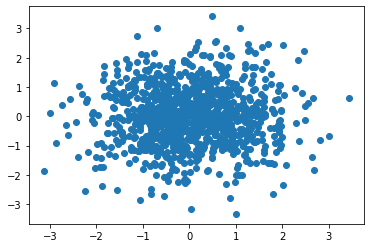

In [36]:
plt.scatter(t[:, 0], t[:, 1])